In [113]:
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [114]:
os.getcwd()

'/Users/ikyajupudy/Kaggle-Humpback-Whale'

In [115]:
sample_size = 1000
TRAIN_DIR = "train"

In [116]:
TRAIN_LABELLING = "train.csv"
all_labels = pd.read_csv(TRAIN_LABELLING).head(sample_size)
all_labels.shape

(1000, 2)

In [117]:
all_labels.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [118]:
y = []
X = []
for _, row in all_labels.iterrows():
    y.append(row['Id'])
    path = os.path.join(TRAIN_DIR, row['Image'])
    img = plt.imread(path)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X.append(img)

y = np.asarray(y)
len(X), y.shape

(1000, (1000,))

(1000, (128, 128))

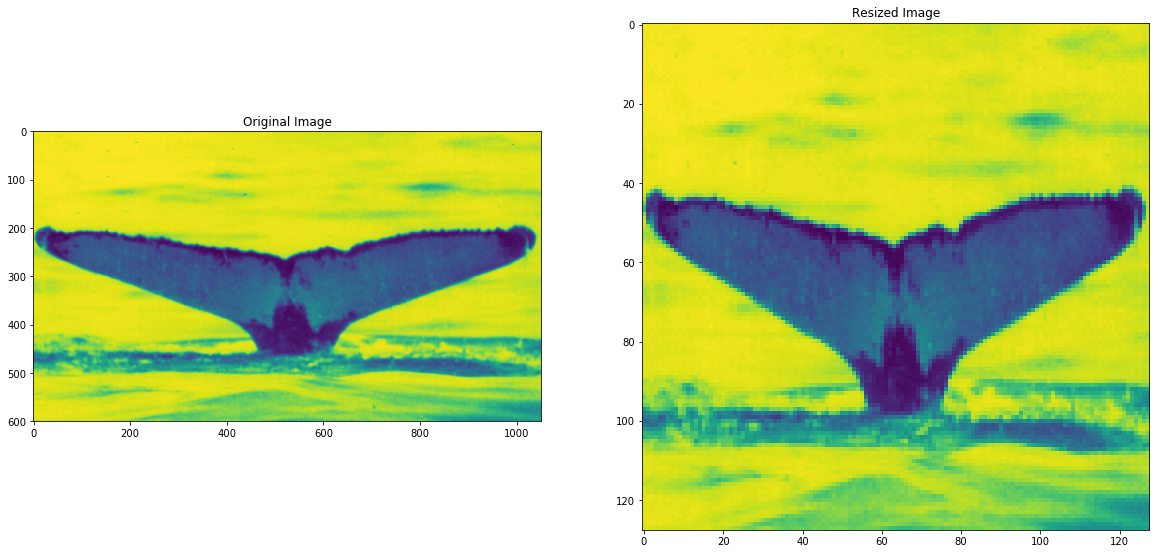

In [119]:
W = 128
H = 128
X_resized = []
for index,img in enumerate(X):
    X_resized.append(cv2.resize(img, (W,H)))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(X[11])
ax[0].set_title('Original Image')
ax[1].imshow(X_resized[11])
ax[1].set_title('Resized Image')
len(X), X_resized[11].shape

(1000, (400, 700))

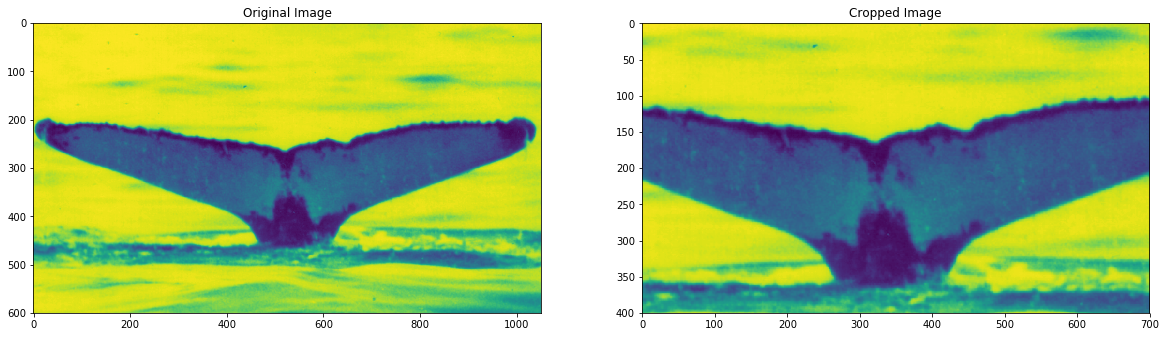

In [120]:
W = 700
H = 400
LEFT = 200
TOP = 100

X_cropped = []
for index,img in enumerate(X):
    X_cropped.append(img[TOP:TOP+H, LEFT:LEFT+W])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(X[11])
ax[0].set_title('Original Image')    
ax[1].imshow(X_cropped[11])
ax[1].set_title('Cropped Image')
len(X), X_cropped[11].shape

### Model

In [160]:
from keras.layers import Dense,Dropout,Conv2D,Flatten,MaxPooling2D
from keras.models import Sequential
import keras.backend as K
from sklearn.model_selection import train_test_split
import skimage as sk
from skimage import transform
from skimage import util
import random
from sklearn.preprocessing import LabelEncoder

In [161]:
def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [162]:
X_train = np.asarray(X_resized[:700])
y_train = np.asarray(y[:700])
X_test = np.asarray(X_resized[700:850])
y_test = np.asarray(y[700:850])
X_val = np.asarray(X_resized[850:])
y_val = np.asarray(y[850:])

In [163]:
Counter((img.shape for img in X_resized))

Counter({(128, 128): 1000})

In [164]:
X_aug_train = []
y_aug_train = []
for img,label in zip(X_train,y_train):
    X_aug_train.append(random_noise(img))
    y_aug_train.append(label)
    X_aug_train.append(random_rotation(img))
    y_aug_train.append(label)
    X_aug_train.append(horizontal_flip(img))
    y_aug_train.append(label)

X_aug_train = np.asarray(X_aug_train)
y_aug_train = np.asarray(y_aug_train)
print(X_train.shape, y_train.shape, X_aug_train.shape, y_aug_train.shape)
X_train = np.concatenate((X_train,X_aug_train), axis = 0)
y_train = np.concatenate((y_train,y_aug_train), axis = 0)

(700, 128, 128) (700,) (2100, 128, 128) (2100,)


In [165]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2800, 128, 128), (2800,), (150, 128, 128), (150,), (150, 128, 128), (150,))

In [149]:
df = pd.read_csv('train.csv')
all_classes = sorted(df['Id'].unique().tolist())
len(all_classes)

5005

In [166]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [167]:
lbl_encoder = LabelEncoder().fit(all_classes)

#### 1.Baseline

In [168]:
model = Sequential()
model.add(Conv2D(8, kernel_size = (5,5), activation = "relu", input_shape = (128,128,1), padding = "same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, kernel_size = (5,5), activation = "relu", padding = "same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, kernel_size = (5,5), activation = "relu", padding = "same"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(len(lbl_encoder.classes_), activation = "relu"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 8)       208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 16)        3216      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 16)        6416      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
__________

In [169]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [170]:
model.fit(
    np.expand_dims(X_train, axis = 3), 
    lbl_encoder.transform(y_train), 
    validation_data = (np.expand_dims(X_val, 3), lbl_encoder.transform(y_val)),
    epochs = 5
)

Train on 2800 samples, validate on 150 samples
Epoch 1/5
2800/2800 [==============================] - 265s 95ms/step - loss: 8.6901 - acc: 0.3664 - val_loss: 8.6151 - val_acc: 0.4333
Epoch 2/5
2800/2800 [==============================] - 242s 86ms/step - loss: 8.5272 - acc: 0.3854 - val_loss: 8.5830 - val_acc: 0.4467
Epoch 3/5
2800/2800 [==============================] - 248s 89ms/step - loss: 8.5311 - acc: 0.3843 - val_loss: 8.6271 - val_acc: 0.4400
Epoch 4/5
2800/2800 [==============================] - 236s 84ms/step - loss: 8.5215 - acc: 0.3864 - val_loss: 8.5333 - val_acc: 0.4600
Epoch 5/5
2800/2800 [==============================] - 209s 75ms/step - loss: 8.5182 - acc: 0.3871 - val_loss: 8.5334 - val_acc: 0.4600
